In [99]:
import torch
from torch import nn
import torch.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
print(torch.__version__)


2.0.0


In [69]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim: list = [500,200,100], activation: nn.Module = nn.Tanh(), use_batchnorm: bool = True):
        super().__init__()
        self.n_hidden = len(hidden_dim)
        self.hidden_dim: list = hidden_dim
        #self.hidden: nn.ModuleList  = nn.ModuleList([nn.Linear(hidden_dim[i],hidden_dim[i+1]) for i in range(len(hidden_dim)-1)]) #store linear layers
        #self.batchnorm: nn.ModuleList = nn.ModuleList([nn.BatchNorm1d(hidden_dim[i],hidden_dim[i+1]) for i in range(1,len(hidden_dim)-1)]) #store batchnorm layers
        self.activation: nn.Module = activation
        self.use_batchnorm: bool = use_batchnorm
        self.sequential = self._get_sequential()

    def _get_sequential(self): #compile to nn.Sequential
        res = nn.Sequential()
        for i, lin in enumerate(self.hidden_dim[:-1]):
            res.append(nn.Linear(self.hidden_dim[i],self.hidden_dim[i+1]))
            res.append(self.activation)
            if self.use_batchnorm and i != self.n_hidden-2:
                res.append(nn.BatchNorm1d(self.hidden_dim[i+1]))
        return res

    def forward(self, x):
        out = self.sequential(x)
        return out

class Decoder(nn.Module):
    def __init__(self, linear: bool = False, hidden_dim: list = [100,200,500], activation: nn.Module = nn.Tanh(), use_batchnorm: bool = False):
        super().__init__()
        assert (linear and len(hidden_dim) == 2) or (not linear)
        self.n_hidden = len(hidden_dim)
        self.hidden_dim: list = hidden_dim
        #self.hidden: nn.ModuleList  = nn.ModuleList([nn.Linear(hidden_dim[i],hidden_dim[i+1]) for i in range(len(hidden_dim)-1)]) #store linear layers
        #self.batchnorm: nn.ModuleList = nn.ModuleList([nn.BatchNorm1d(hidden_dim[i],hidden_dim[i+1]) for i in range(1,len(hidden_dim)-1)]) #store batchnorm layers
        self.activation: nn.Module = activation
        self.use_batchnorm: bool = use_batchnorm
        self.sequential = self._get_sequential()

    def _get_sequential(self): #compile to nn.Sequential
        res = nn.Sequential()
        for i, lin in enumerate(self.hidden_dim[:-1]):
            res.append(nn.Linear(self.hidden_dim[i],self.hidden_dim[i+1]))

            if i < self.n_hidden -2:
                res.append(self.activation)
            if self.use_batchnorm and i < self.n_hidden-2:
                res.append(nn.BatchNorm1d(self.hidden_dim[i+1]))
        return res

    def forward(self, x):
        out = self.sequential(x)
        return out



class AutoEncoder(nn.Module):
    def __init__(self, enc: Encoder, dec: Decoder):
        super().__init__()
        self.enc = enc
        self.dec = dec
        assert dec.hidden_dim[0] == enc.hidden_dim[-1] and dec.hidden_dim[-1] == enc.hidden_dim[0]
    
    def forward(self,x):
        out = self.enc(x)
        out = self.dec(out)
        return out


In [72]:
#Test
input_dim = 500
factor_dim = 20
enc = Encoder(hidden_dim = [input_dim, 200, 100, factor_dim])
X = torch.randn(N, input_dim)
res = enc.forward(X)
print(enc)

#Test
input_dim = 500
factor_dim = 20
dec = Decoder(hidden_dim = [factor_dim, 100, input_dim])
X = torch.randn(N, factor_dim)
res = dec.forward(X)
print(dec)

mod = AutoEncoder(enc, dec)
print(mod)

Encoder(
  (activation): Tanh()
  (sequential): Sequential(
    (0): Linear(in_features=500, out_features=200, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): Tanh()
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=20, bias=True)
    (7): Tanh()
  )
)
Decoder(
  (activation): Tanh()
  (sequential): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=500, bias=True)
  )
)
AutoEncoder(
  (enc): Encoder(
    (activation): Tanh()
    (sequential): Sequential(
      (0): Linear(in_features=500, out_features=200, bias=True)
      (1): Tanh()
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=200, out_features=100, bia

In [80]:
def train(X: torch.utils.data.DataLoader, model: AutoEncoder, n_epoch:int, optimizer: optim.Optimizer, criterion: nn.Module, lr: float = 0.05):
    """
    Vanilla gradient descent using Adam
    """
    optimizer = optimizer(model.parameters(), lr=lr)
    loss_hist = []
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, batch in enumerate(X):
            optimizer.zero_grad()
            out = model(batch)
            loss  = criterion(out, batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_hist.append(running_loss/len(X))
        print(f"Epoch {epoch} | {loss_hist[-1]}")
    return loss_hist

In [81]:
def simulateVar(x0, delta, lamda, T, mu, omega):
    assert delta.shape[0] == x0.shape[0] == lamda.shape[0] == x0.shape[0] == omega.shape[0] == mu.shape[0], 'Incorrect shapes'
    eigval, _ = np.linalg.eig(lamda)
    if not (np.abs(eigval)<=1.).all(): print(f"Warning: this system is unstable. Eigenvalues: {eigval}")
    res = [x0]
    for t in range(T):
        residuals = np.random.multivariate_normal(mu,omega)
        xt = delta + lamda @ res[-1] + residuals
        res.append(xt)
    return np.array(res)

def simulateRandomVar(k, T=100, warmup=0.1):
    D = np.diag(np.random.uniform(0,1, size=(k))) #eigenvalues
    V = np.random.normal(size=(k,k))
    lamda = np.linalg.inv(V) @ D @ V #similarity transform
    #print(np.linalg.eig(lamda))
    x0 = np.random.normal(size=(k))
    delta = np.random.normal(size=(k))
    mu = np.zeros(k)
    omega = np.identity((k))
    res = simulateVar(x0,delta,lamda,T,mu,omega)
    return res[int(0.1*T):]



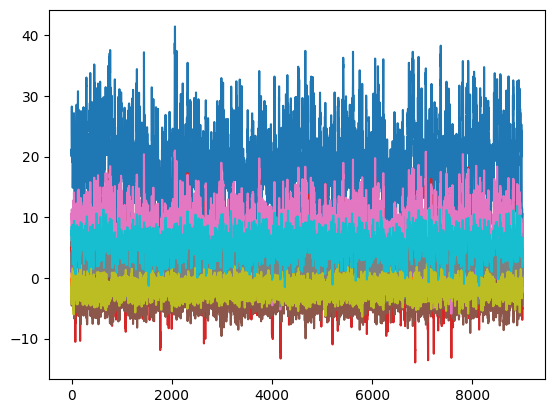

In [82]:
sim = simulateRandomVar(10,T=10000)
plt.plot(sim);

AutoEncoder(
  (enc): Encoder(
    (activation): Identity()
    (sequential): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): Identity()
    )
  )
  (dec): Decoder(
    (activation): Tanh()
    (sequential): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
    )
  )
)
Epoch 0 | 28.96357594596015
Epoch 1 | 7.847590380244785
Epoch 2 | 3.2606539527575173
Epoch 3 | 3.117967234717475
Epoch 4 | 3.031555347972446
Epoch 5 | 2.9554415941238403
Epoch 6 | 2.8838982582092285
Epoch 7 | 2.8162339859538608
Epoch 8 | 2.7520097494125366
Epoch 9 | 2.6909872028562756
Epoch 10 | 2.633005758126577
Epoch 11 | 2.577940308385425
Epoch 12 | 2.525681879785326
Epoch 13 | 2.4761262602276273
Epoch 14 | 2.429170456197527
Epoch 15 | 2.3847117490238614
Epoch 16 | 2.3426493373182087
Epoch 17 | 2.3028836448987327
Epoch 18 | 2.265314575698641
Epoch 19 | 2.229843431048923
Epoch 20 | 2.1963755124145083
Epoch 21 | 2.16481993926896
Epoch 22 | 2.1350891954369016
Epo

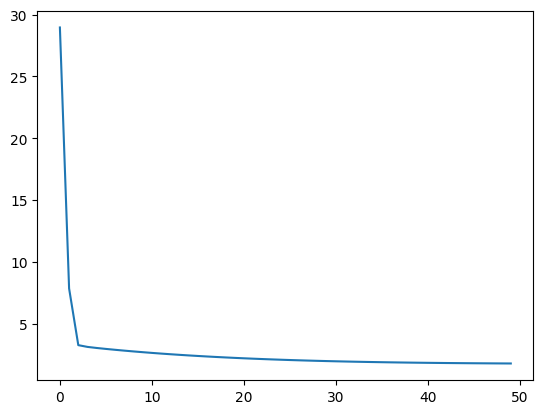

In [113]:
x = torch.from_numpy(sim).float()
dataLoader = torch.utils.data.DataLoader(x, batch_size=256, shuffle=False)
input_dim = 10
factor_dim = 1
enc = Encoder(hidden_dim = [input_dim, factor_dim], activation=nn.Identity()) #fully linear
dec = Decoder(hidden_dim = [factor_dim, input_dim])
model = AutoEncoder(enc, dec)
print(model)
loss_hist = train(X=dataLoader, model=model, n_epoch=50, optimizer=optim.Adam, criterion=nn.MSELoss(), lr=0.01)
plt.plot(loss_hist)

Text(0.5, 1.0, 'First principal component')

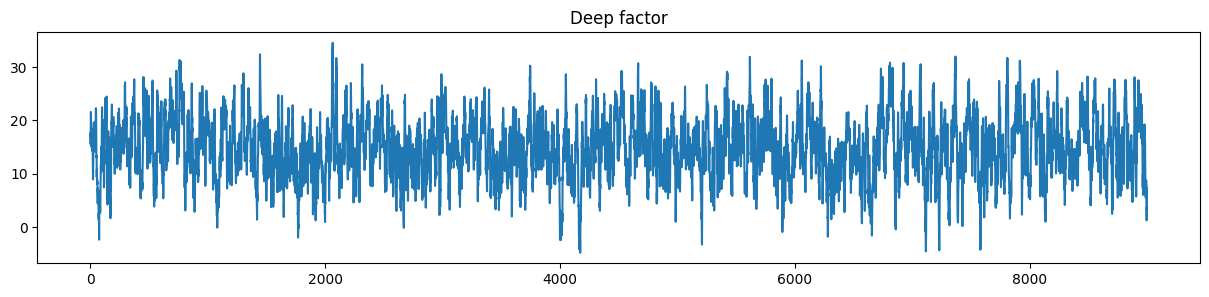

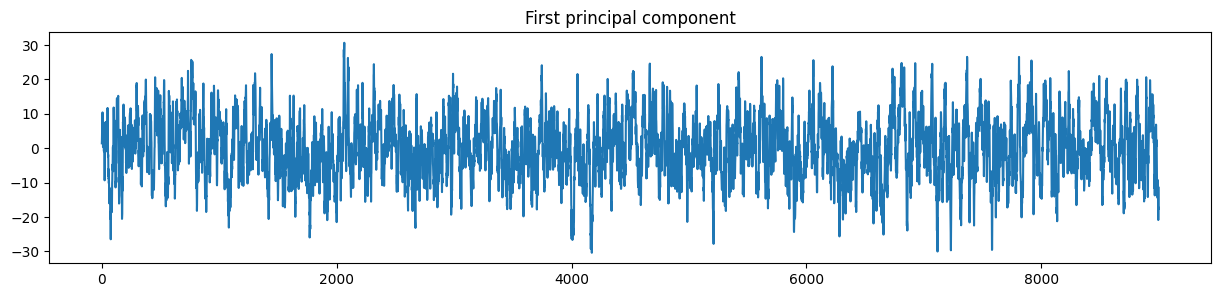

In [112]:
#plot facors
plt.figure(figsize=(15,3))
plt.plot(model.enc(x).detach().numpy());
plt.title('Deep factor')

#compare to PCA
pca = PCA(n_components=1)
pc = pca.fit_transform(x)
plt.figure(figsize=(15,3))
plt.plot(pc);
plt.title('First principal component')
